In [1]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

color_map = {
    "green1": "#66c2a5",
    "orange": "#fc8d62",
    "blue": "#8da0cb",
    "pink": "#e78ac3",
    "green2": "#a6d854",
    "yellow": "#ffd92f",
    "brown": "#e5c494",
    "grey": "#b3b3b3",
}

In [3]:
import glob
import os
import sys
sys.path.append('../tools/')

from dust_extinction import calALambda
from spec_to_flux import spec_to_flux, spec_to_mag
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

## Distance modulus

In [4]:
# SN metadata

z = 0.02736
z_unc = 0.00007
t_max_mjd = 59723.65 # t_0 in salt3
ebv = 0.032
rv = 3.1

# tfl = 58972.46296299994


### IPAC velocity calculator

- $z=0.02736$, $v = cz = 8202.3$ km/s, $v_\mathrm{CMB} = 8346.4$ km/s

### Cosmic flow

- $\Omega_M=0.3$, $h_0=0.7$

In [5]:
cosmo = np.loadtxt('SN2022joj_cosmo.txt')
print('Luminosity distances =', cosmo[6], 'Mpc')

mu = 5 * np.log10(cosmo[6] * 1e6 / 10)
print('Distance modulus = {:.2f}'.format(mu))


Luminosity distances = 119.49 Mpc
Distance modulus = 35.39


## Light curves

In [6]:
import pandas as pd
from astropy.table import Table

In [7]:
# UVOT
joj_UVOT = pd.read_csv(
    "./UVOT_light_curve.dat",
    delimiter=" ",
    names=["time", "flux", "fluxerr", "mag", "mag_unc_u", "mag_unc_l", "lim", "band"],
)
joj_UVOT_u = joj_UVOT[joj_UVOT["band"] == "U"]
joj_UVOT_b = joj_UVOT[joj_UVOT["band"] == "B"]
joj_UVOT_v = joj_UVOT[joj_UVOT["band"] == "V"]
joj_UVOT_uvw1 = joj_UVOT[joj_UVOT["band"] == "UW1"]
joj_UVOT_uvw2 = joj_UVOT[joj_UVOT["band"] == "UW2"]
joj_UVOT_uvm2 = joj_UVOT[joj_UVOT["band"] == "UM2"]
joj_UVOT_u = joj_UVOT[joj_UVOT["band"] == "U"].assign(band="uvot::u")
joj_UVOT_b = joj_UVOT[joj_UVOT["band"] == "B"].assign(band="uvot::b")
joj_UVOT_v = joj_UVOT[joj_UVOT["band"] == "V"].assign(band="uvot::v")
joj_UVOT = pd.concat([joj_UVOT_b, joj_UVOT_v])
joj_UVOT

,time,flux,fluxerr,mag,mag_unc_u,mag_unc_l,lim,band
1,59716.367164,1136.639,51.97174,16.261009,0.048543,0.050815,0,uvot::b
7,59720.061211,1538.784,50.03647,15.932121,0.034743,0.035891,0,uvot::b
13,59720.458733,1551.404,49.66836,15.923253,0.034215,0.035329,0,uvot::b
19,59722.744811,1601.018,47.21167,15.889075,0.031554,0.032498,0,uvot::b
0,59716.371912,1022.627,83.56262,16.375772,0.085281,0.092555,0,uvot::v
6,59720.065345,1414.110,75.12651,16.023857,0.056201,0.059270,0,uvot::v
12,59720.461854,1519.245,76.61914,15.945996,0.053420,0.056185,0,uvot::v
18,59722.750224,1518.869,69.84995,15.946265,0.048817,0.051116,0,uvot::v


In [8]:
def mag1_mag2(X, Y, bin_size=1, flux=False):
    '''
    calculate the color using multi-band photometry
    
    Parameters
    ----------
    X, Y : array-like
        X-, Y-band photometry
        column 1 - obs time (day)
        column 2 - magnitude/flux
        column 3 - (symmetric) uncertainty
        column 4 & 5 (optional) - (upper & lower) uncertainty
    bin_size : float, default = 1 (day)
        the maximum allowed offset of the obs times for the X-
        and Y-band photometry to calculate the color
    flux : bool, default = False
        whether to estimate the color uncertainty from the uncertainty
        of flux ratio, needs column 4 & 5 from X, Y
    '''
    t1, t2 = X[:, 0], Y[:, 0]
    if not flux:
        mag1, mag2 = X[:, 1], Y[:, 1]
        unc1, unc2 = X[:, 2], Y[:, 2]
        i, j = 0, 0
        T = []
        dmag, Unc = [], []
        while i < len(t1):
            while j < len(t2):
                if t2[j] >= t1[i] + bin_size:
                    break
                if (np.abs(t2[j] - t1[i]) < bin_size):
                    t = (t1[i] / unc1[i]**2 + t2[j] / unc2[j]**2) / (
                        1 / unc1[i]**2 + 1 / unc2[j]**2)
                    mag = (mag1[i] - mag2[j])
                    unc = (unc1[i]**2 + unc2[j]**2)**.5
                    T = np.append(T, t)
                    dmag = np.append(dmag, mag)
                    Unc = np.append(Unc, unc)
                    break
                j += 1
            i += 1
        arg = np.argwhere(Unc < 999).flatten()
        return T[arg], dmag[arg], Unc[arg]
    else:
        f1, f2 = X[:, 1], Y[:, 1]
        f_unc1, f_unc2 = X[:, 2], Y[:, 2]
        i, j = 0, 0
        T = []
        dmag, Unc_u, Unc_l = [], [], []
        while i < len(t1):
            while j < len(t2):
                if t2[j] >= t1[i] + bin_size:
                    break
                if (np.abs(t2[j] - t1[i]) < bin_size):
                    if f1[i] <= f_unc1[i] or f2[j] <= f_unc2[j]:
                        j += 1
                        continue
                    f12 = f1[i] / f2[j]
                    f12unc = f12 * ((f_unc1[i] / f1[i])**2 +
                                    (f_unc2[j] / f2[j])**2)**.5
                    t = (t1[i] / f_unc1[i]**2 + t2[j] / f_unc2[j]**2) / (
                        1 / f_unc1[i]**2 + 1 / f_unc2[j]**2)
                    T = np.append(T, t)
                    dmag = np.append(dmag, -2.5 * np.log10(f12))
                    Unc_u = np.append(Unc_u,
                                      -2.5 * np.log10(f12 / (f12 + f12unc)))
                    Unc_l = np.append(Unc_l, -2.5 * np.log10(
                        (f12 - f12unc) / f12))
                    break
                j += 1
            i += 1
        arg = np.argwhere(Unc_l < 999).flatten()
        return T[arg], dmag[arg], [Unc_u[arg], Unc_l[arg]]

In [9]:
leff_uvot_uvw2 = 2075.69
leff_uvot_uvm2 = 2246.56
leff_uvot_uvw1 = 2715.68
leff_uvot_u = 3523.78
leff_uvot_b = 4345.96
leff_uvot_v = 5412.38
# b - v
b_v = mag1_mag2(
    X=np.array(
        [joj_UVOT_b["time"], joj_UVOT_b["flux"], joj_UVOT_b["fluxerr"]]
    ).T,
    Y=np.array([joj_UVOT_v["time"], joj_UVOT_v["flux"], joj_UVOT_v["fluxerr"]]).T,
    bin_size=0.5,
    flux=True,
)
print(
    "b - v = {:.2f} - {:.2f} + {:.2f}".format(
        b_v[1][-1]
        - (
            calALambda(wv=leff_uvot_b, RV=3.1, EBV=ebv)
            - calALambda(wv=leff_uvot_v, RV=3.1, EBV=ebv)
        ),
        b_v[2][0][-1],
        b_v[2][1][-1],
    )
)

# u - v
u_v = mag1_mag2(
    X=np.array(
        [joj_UVOT_u["time"], joj_UVOT_u["flux"], joj_UVOT_u["fluxerr"]]
    ).T,
    Y=np.array([joj_UVOT_v["time"], joj_UVOT_v["flux"], joj_UVOT_v["fluxerr"]]).T,
    bin_size=0.5,
    flux=True,
)
print(
    "u - v = {:.2f} - {:.2f} + {:.2f}".format(
        u_v[1][-1]
        - (
            calALambda(wv=leff_uvot_u, RV=3.1, EBV=ebv)
            - calALambda(wv=leff_uvot_v, RV=3.1, EBV=ebv)
        ),
        b_v[2][0][-1],
        b_v[2][1][-1],
    )
)

# uvw1 - v
uvw1_v = mag1_mag2(
    X=np.array(
        [joj_UVOT_uvw1["time"], joj_UVOT_uvw1["flux"], joj_UVOT_uvw1["fluxerr"]]
    ).T,
    Y=np.array([joj_UVOT_v["time"], joj_UVOT_v["flux"], joj_UVOT_v["fluxerr"]]).T,
    bin_size=0.5,
    flux=True,
)
print(
    "uvw1 - v = {:.2f} - {:.2f} + {:.2f}".format(
        uvw1_v[1][-1]
        - (
            calALambda(wv=leff_uvot_uvw1, RV=3.1, EBV=ebv)
            - calALambda(wv=leff_uvot_v, RV=3.1, EBV=ebv)
        ),
        uvw1_v[2][0][-1],
        uvw1_v[2][1][-1],
    )
)

# uvm2 - uvw1
uvm2_uvw1 = mag1_mag2(
    X=np.array(
        [joj_UVOT_uvm2["time"], joj_UVOT_uvm2["flux"], joj_UVOT_uvm2["fluxerr"]]
    ).T,
    Y=np.array(
        [joj_UVOT_uvw1["time"], joj_UVOT_uvw1["flux"], joj_UVOT_uvw1["fluxerr"]]
    ).T,
    bin_size=0.5,
    flux=True,
)
print(
    "uvm2 - uvw1 = {:.2f} - {:.2f} + {:.2f}".format(
        uvm2_uvw1[1][-1]
        - (
            calALambda(wv=leff_uvot_uvw1, RV=3.1, EBV=ebv)
            - calALambda(wv=leff_uvot_v, RV=3.1, EBV=ebv)
        ),
        uvm2_uvw1[2][0][-1],
        uvm2_uvw1[2][1][-1],
    )
)

b - v = -0.09 - 0.06 + 0.06
u - v = 1.59 - 0.06 + 0.06
uvw1 - v = 3.99 - 0.19 + 0.23
uvm2 - uvw1 = 1.52 - 0.33 + 0.48


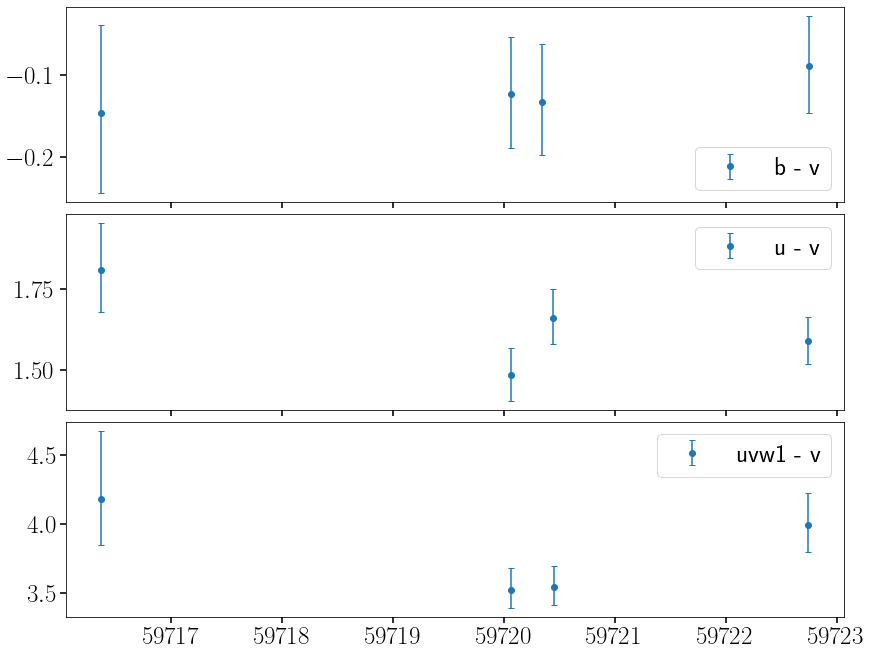

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(12, 9), constrained_layout=True, sharex=True)
ax[0].errorbar(
    b_v[0],
    b_v[1]
    - (
        calALambda(wv=leff_uvot_b, RV=3.1, EBV=ebv)
        - calALambda(wv=leff_uvot_v, RV=3.1, EBV=ebv)
    ),
    yerr=b_v[2],
    fmt="o",
    capsize=3,
    label="b - v",
)
ax[1].errorbar(
    u_v[0],
    u_v[1]
    - (
        calALambda(wv=leff_uvot_u, RV=3.1, EBV=ebv)
        - calALambda(wv=leff_uvot_v, RV=3.1, EBV=ebv)
    ),
    yerr=u_v[2],
    fmt="o",
    capsize=3,
    label="u - v",
)
ax[2].errorbar(
    uvw1_v[0],
    uvw1_v[1]
    - (
        calALambda(wv=leff_uvot_uvw1, RV=3.1, EBV=ebv)
        - calALambda(wv=leff_uvot_v, RV=3.1, EBV=ebv)
    ),
    yerr=uvw1_v[2],
    fmt="o",
    capsize=3,
    label="uvw1 - v",
)

for a in ax:
    a.legend()

In [11]:
joj_UVOT_b["mag"].min() - mu - calALambda(
    wv=leff_uvot_b, RV=3.1, EBV=ebv
), joj_UVOT_b.loc[joj_UVOT_b.index[joj_UVOT_b["mag"].argmin()]]

(-19.629024047838158,
 time         59722.744811
 flux             1601.018
 fluxerr          47.21167
 mag             15.889075
 mag_unc_u        0.031554
 mag_unc_l        0.032498
 lim                     0
 band              uvot::b
 Name: 19, dtype: object)

In [12]:
joj_UVOT_u["mag"].min() - mu - calALambda(
    wv=leff_uvot_u, RV=3.1, EBV=ebv
), joj_UVOT_u.loc[joj_UVOT_u.index[joj_UVOT_u["mag"].argmin()]]

(-17.979746583538635,
 time         59720.060356
 flux              342.684
 fluxerr          18.56192
 mag             17.562831
 mag_unc_u        0.057273
 mag_unc_l        0.060463
 lim                     0
 band              uvot::u
 Name: 8, dtype: object)

In [13]:
with open("./UVOT_sample.txt", "r") as f:
    lines = f.readlines()
UVOT_mag_sample = np.empty((5, 28))
UVOT_mag_err_sample = np.empty((5, 28))

k = 0
for line in lines:
    if line.split()[0][0] == '#': continue
    line = line.replace("−", "-")
    line = line.replace("L", "nan")
    dat = line.split()
    mag = [float(d.split("\uf0a0")[0]) for d in dat]
    mag_err = [float(d.split("\uf0a0")[-1]) for d in dat]
    UVOT_mag_sample[k, :] = mag
    UVOT_mag_err_sample[k, :] = mag_err
    k += 1

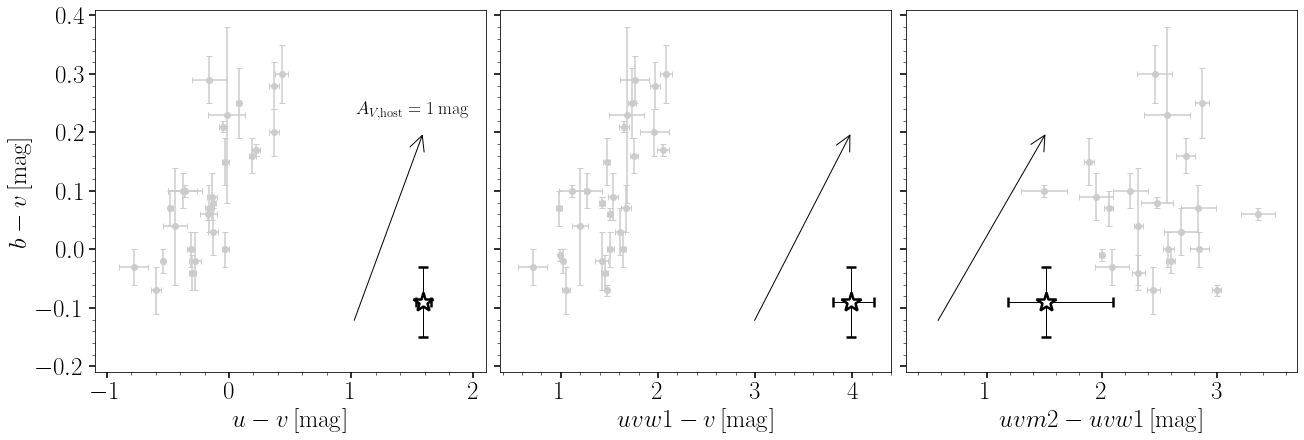

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True, sharey=True)
ax[0].errorbar(
    UVOT_mag_sample[2, :],
    UVOT_mag_sample[1, :],
    fmt="o",
    xerr=UVOT_mag_err_sample[2, :],
    yerr=UVOT_mag_err_sample[1, :],
    capsize=3,
    color="0.8",
)
ax[1].errorbar(
    UVOT_mag_sample[3, :],
    UVOT_mag_sample[1, :],
    fmt="o",
    xerr=UVOT_mag_err_sample[3, :],
    yerr=UVOT_mag_err_sample[1, :],
    capsize=3,
    color="0.8",
)
ax[2].errorbar(
    UVOT_mag_sample[4, :],
    UVOT_mag_sample[1, :],
    fmt="o",
    xerr=UVOT_mag_err_sample[4, :],
    yerr=UVOT_mag_err_sample[1, :],
    capsize=3,
    color="0.8",
)

# b - v = -0.09 - 0.06 + 0.06
# u - v = 1.59 - 0.06 + 0.06
# uvw1 - v = 3.99 - 0.19 + 0.23
# uvm2 - uvw1 = 1.52 - 0.33 + 0.48

color_style = dict(
    fmt="*",
    ms=20,
    color="k",
    capsize=5,
    markerfacecolor="w",
    zorder=10,
    linewidth=1,
    markeredgewidth=2.5,
)
arrow_style = dict(
    arrowprops={"arrowstyle": "->, head_width=.3, head_length=.6", "linestyle": "-", "linewidth":1.},
    text="",
    ha="center",
    va="center",
)

ax[0].errorbar(1.59, -0.09, xerr=0.06, yerr=0.06, **color_style)
ax[0].annotate(
    xy=(1.59, .2),
    xytext=(
        1.59
        - (
            calALambda(leff_uvot_u, EBV=1 / 3.1, RV=3.1)
            - calALambda(leff_uvot_v, EBV=1 / 3.1, RV=3.1)
        ),
        .2
        - (
            calALambda(leff_uvot_b, EBV=1 / 3.1, RV=3.1)
            - calALambda(leff_uvot_v, EBV=1 / 3.1, RV=3.1)
        ),
    ),
    **arrow_style,
)
ax[0].text(
    1.5, 0.23, r"$A_{V,\mathrm{host}} = 1\,\mathrm{mag}$", fontsize=18, ha="center"
)

ax[1].errorbar(3.99, -0.09, xerr=[[0.19], [0.23]], yerr=0.06, **color_style)
ax[1].annotate(
    xy=(3.99, .2),
    xytext=(
        3.99
        - (
            calALambda(leff_uvot_uvw1, EBV=1 / 3.1, RV=3.1)
            - calALambda(leff_uvot_v, EBV=1 / 3.1, RV=3.1)
        ),
        .2
        - (
            calALambda(leff_uvot_b, EBV=1 / 3.1, RV=3.1)
            - calALambda(leff_uvot_v, EBV=1 / 3.1, RV=3.1)
        ),
    ),
    **arrow_style,
)
ax[2].errorbar(1.52, -0.09, xerr=[[0.33], [0.58]], yerr=0.06, **color_style)
ax[2].annotate(
    xy=(1.52, .2),
    xytext=(
        1.52
        - (
            calALambda(leff_uvot_uvm2, EBV=1 / 3.1, RV=3.1)
            - calALambda(leff_uvot_uvw1, EBV=1 / 3.1, RV=3.1)
        ),
        .2
        - (
            calALambda(leff_uvot_b, EBV=1 / 3.1, RV=3.1)
            - calALambda(leff_uvot_v, EBV=1 / 3.1, RV=3.1)
        ),
    ),
    **arrow_style,
)
ax[0].set_xlabel("$u - v\,[\mathrm{mag}]$")
ax[1].set_xlabel("$uvw1 - v\,[\mathrm{mag}]$")
ax[2].set_xlabel("$uvm2 - uvw1\,[\mathrm{mag}]$")
ax[0].set_ylabel("$b - v\,[\mathrm{mag}]$")

for a in ax:
    a.xaxis.set_major_locator(MultipleLocator(1))
    a.xaxis.set_minor_locator(MultipleLocator(0.2))
ax[0].set_xlim(-1.1, 2.1)
ax[2].set_xlim(0.3, 3.7)

ax[0].yaxis.set_minor_locator(MultipleLocator(0.02))
ax[0].set_ylim(-0.21, 0.41)

plt.savefig("../paper/figures/UVOT_colors.pdf", bbox_inches="tight")

Text(0, 0.5, '$F_\\lambda\\ [\\mathrm{erg\\,cm^{-2}\\,s^{-1}\\,\\r{A}^{-1}}]$')

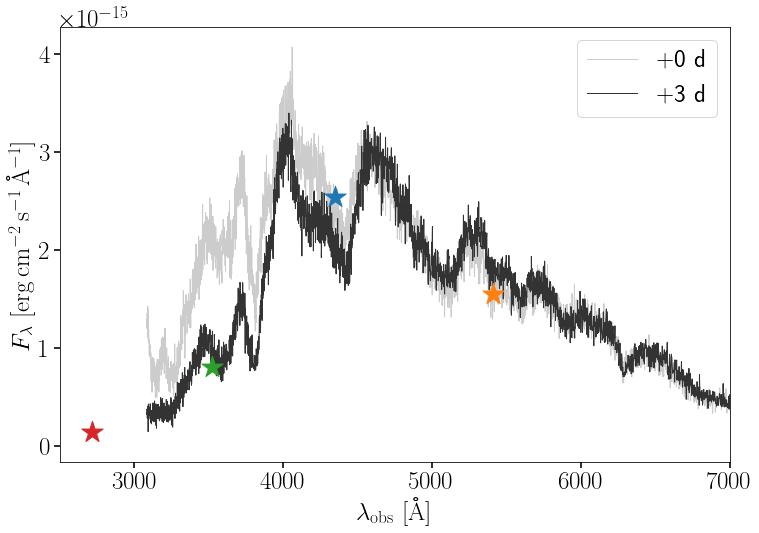

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
spec_syn_0 = np.loadtxt("./Shen+21_model/m_1.0_dens_14e5_mu_-67_phase_0_spec.txt")
spec_syn_3 = np.loadtxt("./Shen+21_model/m_1.0_dens_14e5_mu_-67_phase_3_spec.txt")
ax.plot(spec_syn_0[:, 0], spec_syn_0[:, 1] * (10e-6 / 114.48) ** 2, lw=1, label='+0 d', color='0.8')
ax.plot(spec_syn_3[:, 0], spec_syn_3[:, 1] * (10e-6 / 114.48) ** 2, lw=1, label='+3 d', color='0.2')

c = 2.99792458e10
ax.scatter(
    leff_uvot_b,
    joj_UVOT_b["flux"].values[-1] * 1e-6 * 1e-23 * c / (leff_uvot_b**2 * 1e-8), zorder=100, marker='*', s=500
)
ax.scatter(
    leff_uvot_v,
    joj_UVOT_v["flux"].values[-1] * 1e-6 * 1e-23 * c / (leff_uvot_v**2 * 1e-8), zorder=100, marker='*', s=500
)

ax.scatter(
    leff_uvot_u,
    joj_UVOT_u["flux"].values[-1] * 1e-6 * 1e-23 * c / (leff_uvot_u**2 * 1e-8), zorder=100, marker='*', s=500
)
ax.scatter(
    leff_uvot_uvw1,
    joj_UVOT_uvw1["flux"].values[-1] * 1e-6 * 1e-23 * c / (leff_uvot_uvw1**2 * 1e-8), zorder=100, marker='*', s=500
)

ax.set_xlim(2500, 7000)

ax.legend()
ax.set_xlabel(r'$\lambda_\mathrm{obs}\ [\mathrm{\r{A}}]$')
ax.set_ylabel(r'$F_\lambda\ [\mathrm{erg\,cm^{-2}\,s^{-1}\,\r{A}^{-1}}]$')

In [16]:
joj_UVOT_v["flux"].values[-1]

1518.869